In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
data = pd.read_csv("nn/max_mag_by_month.csv")
data.head()

,time,A,B,C,D,E,F,G
0,1960-01-01,0.0,0.0,0.0,6.3,0.0,0.0,0.0
1,1960-02-01,0.0,0.0,0.0,0.0,0.0,6.1,0.0
2,1960-03-01,0.0,0.0,0.0,0.0,0.0,8.0,0.0
3,1960-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1960-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
dataA = data.A[data.A > 4]

(array([  4.,   5.,  43.,  35.,  49., 122.,  49.,  51.,  79.,  29.,  31.,
         28.,  16.,  12.,  30.,   5.,   9.,   4.,   1.,   9.,   1.,   2.,
          3.,   0.,   0.,   1.,   1.,   0.,   1.,   1.]),
 array([4.1       , 4.23533333, 4.37066667, 4.506     , 4.64133333,
        4.77666667, 4.912     , 5.04733333, 5.18266667, 5.318     ,
        5.45333333, 5.58866667, 5.724     , 5.85933333, 5.99466667,
        6.13      , 6.26533333, 6.40066667, 6.536     , 6.67133333,
        6.80666667, 6.942     , 7.07733333, 7.21266667, 7.348     ,
        7.48333333, 7.61866667, 7.754     , 7.88933333, 8.02466667,
        8.16      ]),
 <BarContainer object of 30 artists>)

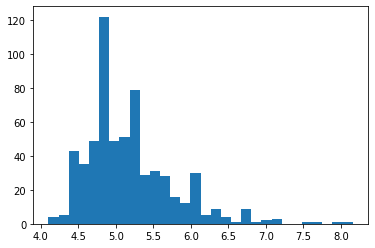

In [4]:
plt.hist(dataA, bins=30)

In [5]:
dataA_scaled = (dataA - 4) / dataA.std()   # b_k = 4 et a_k = std

<AxesSubplot:xlabel='A', ylabel='Density'>

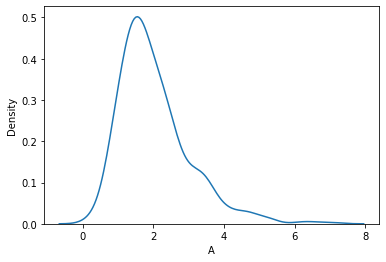

In [6]:
sns.kdeplot(dataA_scaled)

In [7]:
from scipy.stats import genextreme as gnx

In [8]:
param = gnx.fit(dataA_scaled)

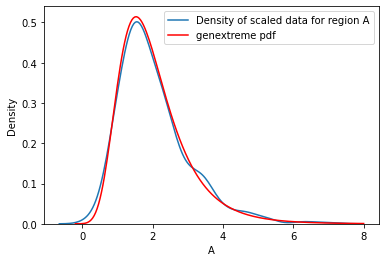

In [9]:
c, loc, scale = param
x = np.linspace(-.2, 8, 200)

sns.kdeplot(dataA_scaled, label='Density of scaled data for region A')
plt.plot(x, gnx.pdf(x, *param), color='red', label='genextreme pdf')
plt.legend()

Let's simulate multiple trajectories

In [20]:
dataA.index = data[data.A > 4]['time']

In [21]:
dataA

time
1960-06-01    5.6
1961-08-01    7.1
1961-11-01    6.5
1962-01-01    6.0
1962-02-01    6.1
             ... 
2021-08-01    4.5
2021-09-01    4.7
2021-10-01    5.3
2021-11-01    4.6
2021-12-01    5.1
Name: A, Length: 621, dtype: float64

In [22]:
r = gnx.rvs(c, size=10)

In [24]:
r*dataA.std() + 4  # inverse transform (scaling)

array([4.63785319, 4.69415445, 4.45396992, 3.88953872, 7.53695598,
       6.4634174 , 7.02924391, 4.47837747, 4.37343545, 4.71712907])

In [34]:
n_sample = 100

In [39]:
S = np.zeros((240, n_sample))  # 100 trajectoires sur les 20 dernières années 

In [40]:
for i in range(n_sample):
    r = gnx.rvs(c, size=240)
    S[:,i] = r*dataA.std() + 4

In [71]:
mean = S.mean(axis=1)
sd = S.std(axis=1)
lb68 = mean - sd/np.sqrt(n_sample)
ub68 = mean + sd/np.sqrt(n_sample)
lb95 = mean - 2*sd/np.sqrt(n_sample)
ub95 = mean + 2*sd/np.sqrt(n_sample)
traj = S[:, 4]
max_pred = S.max(axis=1)

In [73]:
dataplot = pd.DataFrame({"Ground Truth": data.iloc[-240:,1], "mean": mean, "lower_bound_68%": lb68, "upper_bound_68%": ub68, "lower_bound_95%": lb95, "upper_bound_95%": ub95, "Prediction": traj, "Max_pred": max_pred})

In [54]:
ix= pd.to_datetime(data.time)

In [74]:
dataplot.index = ix[-240:]

In [75]:
dataplot.head()

,Ground Truth,mean,lower_bound_68%,upper_bound_68%,lower_bound_95%,upper_bound_95%,Prediction,Max_pred
time,,,,,,,,
2002-01-01,4.7,4.343003,4.277067,4.408938,4.211131,4.474874,5.767916,6.110081
2002-02-01,5.5,4.349602,4.280903,4.418302,4.212203,4.487001,4.866252,6.894502
2002-03-01,4.7,4.399923,4.313270,4.486576,4.226616,4.573229,4.251136,8.211908
2002-04-01,5.7,4.265314,4.193551,4.337076,4.121789,4.408839,4.260933,6.723024
2002-05-01,5.1,4.238585,4.179348,4.297822,4.120112,4.357059,4.327210,7.270817


In [88]:
import plotly.graph_objects as go

upper_trace_68 = go.Scatter(
    x=dataplot.index,
    y=dataplot['upper_bound_68%'],
    mode='lines',
    fill=None,
    name='68% Upper Confidence Bound'
    )
lower_trace_68 = go.Scatter(
    x=dataplot.index,
    y=dataplot['lower_bound_68%'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.1)',
    name='68% Lower Confidence Bound'
    )
real_trace = go.Scatter(
    x=dataplot.index,
    y=dataplot['Ground Truth'],
    mode='lines',
    fill=None,
    name='Real Values'
    )

predicted_trace = go.Scatter(
    x=dataplot.index,
    y=dataplot['Prediction'],
    mode='lines',
    fill=None,
    name='Predicted Values'
    )

data2 = [upper_trace_68, lower_trace_68, real_trace, predicted_trace]

fig = go.Figure(data=data2)
fig.update_layout(title=f'Magnitude prediction using a GEV({param[0]:.2f}, {param[1]:.2f}, {param[2]:.2f}) distribution',
                   xaxis_title='Time',
                   yaxis_title='EQ magnitude')

fig.show()

In [78]:
param

(-0.06021746279628701, 1.5675285385167066, 0.716707957443798)